In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from IPython import display

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
print("Load thu vien xong")

Load thu vien xong


In [2]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
df_test.isna().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [5]:
def drop_missing_columns(df, threshold=0.4):
    missing_ratio = df.isna().mean()
    missing_columns = missing_ratio[missing_ratio > threshold].index.tolist()
    print(f'Dropping {len(missing_columns)} columns with more than {threshold*100}% missing values.')
    print(f'Columns to drop: {missing_columns}')
    
    # Drop columns and return the modified DataFrame
    df_dropped = df.drop(columns=missing_columns)
    return df_dropped

In [6]:
df_output = df_train.copy()

In [7]:
df_output = drop_missing_columns(df_output, threshold=0.4)

Dropping 6 columns with more than 40.0% missing values.
Columns to drop: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [8]:
def drop_zero_columns(df, threshold=0.5):
    # Calculate ratio of zeros in each column
    zero_ratio = (df == 0).astype(int).mean()
    zero_columns = zero_ratio[zero_ratio > threshold].index.tolist()
    
    print(f'Dropping {len(zero_columns)} columns with more than {threshold*100}% zero values.')
    print(f'Columns to drop: {zero_columns}')
    
    # Drop the columns
    df_dropped = df.drop(columns=zero_columns)
    return df_dropped

In [9]:
df_output = drop_zero_columns(df_output, threshold=0.5)

Dropping 13 columns with more than 50.0% zero values.
Columns to drop: ['MasVnrArea', 'BsmtFinSF2', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [10]:
df_output

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,GarageArea,GarageQual,GarageCond,PavedDrive,OpenPorchSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,548,TA,TA,Y,61,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,460,TA,TA,Y,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,608,TA,TA,Y,42,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,642,TA,TA,Y,35,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,836,TA,TA,Y,84,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,460,TA,TA,Y,40,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,500,TA,TA,Y,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,252,TA,TA,Y,60,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,240,TA,TA,Y,0,4,2010,WD,Normal,142125


In [11]:
def engineer_number_columns(df):
    numeric_cols = df_output.select_dtypes(include=[np.number]).columns.tolist()
    correlations = df_output[numeric_cols].corr()['SalePrice'].sort_values(ascending=False)
    feature_number = correlations[correlations.abs() > 0.4].index.tolist()
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_output[feature_number].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    np.unique(feature_number)
    return feature_number

In [12]:
def engineer_object_columns(df):
    object_cols=df_output.select_dtypes(include=['object']).columns.tolist()
    skewed_features=[]
    for col in object_cols:
        value_counts=df_output[col].value_counts(normalize=True)
        max_proportion=value_counts.max()
        if  max_proportion<0.8:
            skewed_features.append(col)
    return skewed_features

In [13]:
def engineer_object_columns1(df):
    features_ob = ['BsmtExposure','BsmtFinType1','BsmtQual','Exterior1st','Exterior2nd','ExterQual','Foundation','GarageFinish','GarageType','HeatingQC','HouseStyle','KitchenQual','LandSlope','LotConfig','LotShape','MSZoning','Neighborhood','RoofStyle','SaleCondition','YrSold']
    return features_ob

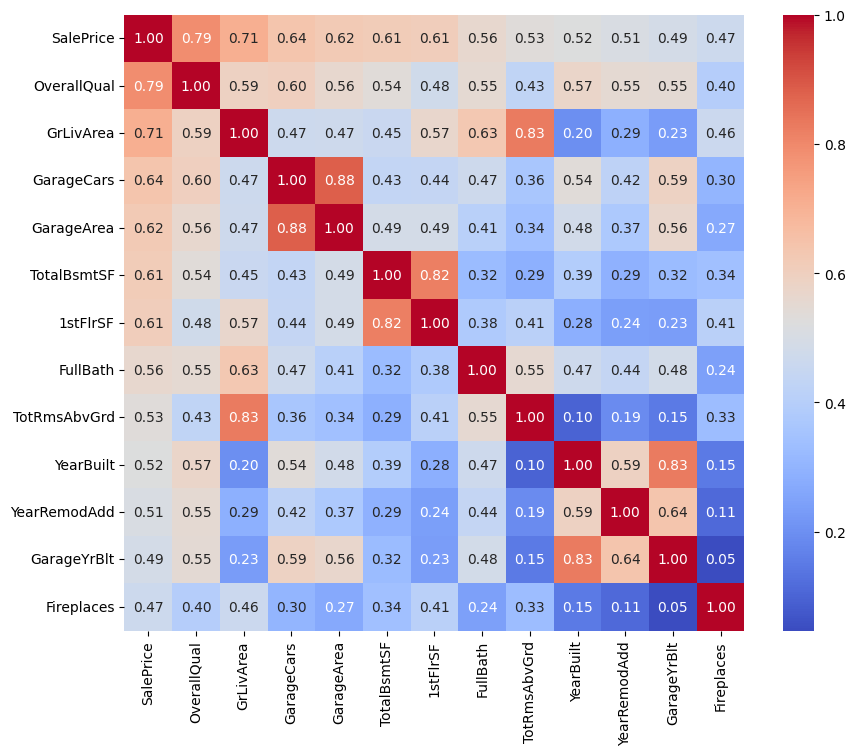

In [14]:
final_feature = engineer_number_columns(df_output) + engineer_object_columns1(df_output)

In [15]:
len(final_feature)

33

In [16]:
final_feature

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'Fireplaces',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtQual',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'Foundation',
 'GarageFinish',
 'GarageType',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'Neighborhood',
 'RoofStyle',
 'SaleCondition',
 'YrSold']

In [17]:
df_train[final_feature].isnull().sum().sort_values(ascending=False)

GarageYrBlt      81
GarageType       81
GarageFinish     81
BsmtExposure     38
BsmtQual         37
BsmtFinType1     37
SalePrice         0
OverallQual       0
GrLivArea         0
TotRmsAbvGrd      0
FullBath          0
1stFlrSF          0
TotalBsmtSF       0
Fireplaces        0
YearRemodAdd      0
GarageCars        0
GarageArea        0
Exterior1st       0
YearBuilt         0
ExterQual         0
Exterior2nd       0
Foundation        0
HeatingQC         0
HouseStyle        0
KitchenQual       0
LandSlope         0
LotConfig         0
LotShape          0
MSZoning          0
Neighborhood      0
RoofStyle         0
SaleCondition     0
YrSold            0
dtype: int64

In [18]:
cols_fill_none = ['GarageType', 'GarageFinish', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1']
df_train[cols_fill_none]=df_train[cols_fill_none].fillna('None')

df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])


In [19]:
df_train[final_feature].isnull().sum().sort_values(ascending=False)

SalePrice        0
OverallQual      0
GrLivArea        0
GarageCars       0
GarageArea       0
TotalBsmtSF      0
1stFlrSF         0
FullBath         0
TotRmsAbvGrd     0
YearBuilt        0
YearRemodAdd     0
GarageYrBlt      0
Fireplaces       0
BsmtExposure     0
BsmtFinType1     0
BsmtQual         0
Exterior1st      0
Exterior2nd      0
ExterQual        0
Foundation       0
GarageFinish     0
GarageType       0
HeatingQC        0
HouseStyle       0
KitchenQual      0
LandSlope        0
LotConfig        0
LotShape         0
MSZoning         0
Neighborhood     0
RoofStyle        0
SaleCondition    0
YrSold           0
dtype: int64

# FE

In [20]:
df_train['Foundation'].unique()

array(['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], dtype=object)

In [21]:
type(final_feature)

list

In [22]:
cat_cols=df_train[final_feature].select_dtypes(include=['object']).columns.tolist()
num_cols=df_train[final_feature].select_dtypes(include=['number']).columns.tolist()
print("cac cot catogorical:  ",cat_cols)
print("cac cot numeric : ",num_cols)

cac cot catogorical:   ['BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'Foundation', 'GarageFinish', 'GarageType', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'Neighborhood', 'RoofStyle', 'SaleCondition']
cac cot numeric :  ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'Fireplaces', 'YrSold']


In [23]:
def check_thong_tin_1_cot(df, col, threshold=0.01):
    print(f"\n===== Column: {col}")
    if col not in df.columns:
        print(f"⚠️ Cột '{col}' không tồn tại trong DataFrame.")
        return df  # tránh lỗi NoneType
    
    vc = df[col].value_counts(normalize=True, dropna=False)

    for cat, pct in vc.items():
        count = df[col].value_counts()[cat]
        print(f"'{cat}' : xuất hiện {count} lần, chiếm {pct:.2%}")

    rare_cats = vc[vc < threshold].index
    if len(rare_cats) > 0:
        print(f"👉 Các giá trị hiếm (<{threshold*100:.0f}%): {list(rare_cats)} -> sẽ gộp thành 'Other'")
        df[col] = df[col].replace(rare_cats, 'Other')
    else:
        print("✅ Không có giá trị hiếm.")
    
    return df


def check_thong_tin_nhieu_cot(df, cols, threshold=0.01):
    for col in cols:
        df = check_thong_tin_1_cot(df, col, threshold)
    return df


In [24]:
check_thong_tin_1_cot(df_train,'Foundation',threshold=0.01)


===== Column: Foundation
'PConc' : xuất hiện 647 lần, chiếm 44.32%
'CBlock' : xuất hiện 634 lần, chiếm 43.42%
'BrkTil' : xuất hiện 146 lần, chiếm 10.00%
'Slab' : xuất hiện 24 lần, chiếm 1.64%
'Stone' : xuất hiện 6 lần, chiếm 0.41%
'Wood' : xuất hiện 3 lần, chiếm 0.21%
👉 Các giá trị hiếm (<1%): ['Stone', 'Wood'] -> sẽ gộp thành 'Other'


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [25]:
df_train = check_thong_tin_nhieu_cot(df_train, cat_cols, threshold=0.01)



===== Column: BsmtExposure
'No' : xuất hiện 953 lần, chiếm 65.27%
'Av' : xuất hiện 221 lần, chiếm 15.14%
'Gd' : xuất hiện 134 lần, chiếm 9.18%
'Mn' : xuất hiện 114 lần, chiếm 7.81%
'None' : xuất hiện 38 lần, chiếm 2.60%
✅ Không có giá trị hiếm.

===== Column: BsmtFinType1
'Unf' : xuất hiện 430 lần, chiếm 29.45%
'GLQ' : xuất hiện 418 lần, chiếm 28.63%
'ALQ' : xuất hiện 220 lần, chiếm 15.07%
'BLQ' : xuất hiện 148 lần, chiếm 10.14%
'Rec' : xuất hiện 133 lần, chiếm 9.11%
'LwQ' : xuất hiện 74 lần, chiếm 5.07%
'None' : xuất hiện 37 lần, chiếm 2.53%
✅ Không có giá trị hiếm.

===== Column: BsmtQual
'TA' : xuất hiện 649 lần, chiếm 44.45%
'Gd' : xuất hiện 618 lần, chiếm 42.33%
'Ex' : xuất hiện 121 lần, chiếm 8.29%
'None' : xuất hiện 37 lần, chiếm 2.53%
'Fa' : xuất hiện 35 lần, chiếm 2.40%
✅ Không có giá trị hiếm.

===== Column: Exterior1st
'VinylSd' : xuất hiện 515 lần, chiếm 35.27%
'HdBoard' : xuất hiện 222 lần, chiếm 15.21%
'MetalSd' : xuất hiện 220 lần, chiếm 15.07%
'Wd Sdng' : xuất hiện 206

In [26]:
def feature_diagnose_simple(df, feature_col, target_col=None):
    """
    Chẩn đoán nhanh 1 feature số:
    - Phát hiện missing, outlier, skew
    - Gợi ý xử lý tiếp theo
    """
    s = df[feature_col]

    # Kiểm tra loại dữ liệu
    if not np.issubdtype(s.dtype, np.number):
        print(f"⚠️ Cột {feature_col} không phải numeric, bỏ qua.")
        return

    print(f"\n===== Feature: {feature_col} =====")
    print(f"Count: {s.count()}, Missing: {s.isna().sum()} ({s.isna().mean():.2%}), Unique: {s.nunique()}")
    print(f"Mean: {s.mean():.2f}, Median: {s.median():.2f}, Std: {s.std():.2f}, Skew: {s.skew():.2f}")

    # IQR outliers
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_ratio = ((s < lower) | (s > upper)).mean()
    print(f"Outliers (IQR rule): {outlier_ratio:.2%}")

    # Correlation nếu có target
    if target_col is not None:
        corr = df[[feature_col, target_col]].corr().iloc[0,1]
        print(f"Corr({feature_col}, {target_col}) = {corr:.3f}")

    # Gợi ý xử lý
    suggestions = []
    if s.isna().mean() > 0:
        suggestions.append("→ Có missing: nên impute (median hoặc model-based).")
    if outlier_ratio > 0.05:
        suggestions.append("→ Có >5% outliers: nên winsorize hoặc clip.")
    if abs(s.skew()) > 1:
        suggestions.append("→ Skew cao: nên log1p hoặc Yeo-Johnson.")
    elif abs(s.skew()) > 0.5:
        suggestions.append("→ Skew vừa: cân nhắc transform nhẹ.")
    else:
        suggestions.append("→ Phân phối cân bằng: giữ nguyên.")

    print("🩺 Suggestions:")
    for sgg in suggestions:
        print(" ", sgg)


In [27]:
feature_diagnose_simple(df_train, 'GrLivArea', target_col='SalePrice')



===== Feature: GrLivArea =====
Count: 1460, Missing: 0 (0.00%), Unique: 861
Mean: 1515.46, Median: 1464.00, Std: 525.48, Skew: 1.37
Outliers (IQR rule): 2.12%
Corr(GrLivArea, SalePrice) = 0.709
🩺 Suggestions:
  → Skew cao: nên log1p hoặc Yeo-Johnson.


In [28]:
for col in num_cols:
    if col != 'SalePrice':   # bỏ cột target
        feature_diagnose_simple(df_train, col, target_col='SalePrice')


===== Feature: OverallQual =====
Count: 1460, Missing: 0 (0.00%), Unique: 10
Mean: 6.10, Median: 6.00, Std: 1.38, Skew: 0.22
Outliers (IQR rule): 0.14%
Corr(OverallQual, SalePrice) = 0.791
🩺 Suggestions:
  → Phân phối cân bằng: giữ nguyên.

===== Feature: GrLivArea =====
Count: 1460, Missing: 0 (0.00%), Unique: 861
Mean: 1515.46, Median: 1464.00, Std: 525.48, Skew: 1.37
Outliers (IQR rule): 2.12%
Corr(GrLivArea, SalePrice) = 0.709
🩺 Suggestions:
  → Skew cao: nên log1p hoặc Yeo-Johnson.

===== Feature: GarageCars =====
Count: 1460, Missing: 0 (0.00%), Unique: 5
Mean: 1.77, Median: 2.00, Std: 0.75, Skew: -0.34
Outliers (IQR rule): 0.34%
Corr(GarageCars, SalePrice) = 0.640
🩺 Suggestions:
  → Phân phối cân bằng: giữ nguyên.

===== Feature: GarageArea =====
Count: 1460, Missing: 0 (0.00%), Unique: 441
Mean: 472.98, Median: 480.00, Std: 213.80, Skew: 0.18
Outliers (IQR rule): 1.44%
Corr(GarageArea, SalePrice) = 0.623
🩺 Suggestions:
  → Phân phối cân bằng: giữ nguyên.

===== Feature: TotalB

In [29]:
cols_log1p = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF']
for col in cols_log1p:
    df_train[col] = np.log1p(df_train[col])


In [30]:
from sklearn.preprocessing import StandardScaler
cols_keep = ['OverallQual', 'GarageCars', 'GarageArea',
             'FullBath', 'TotRmsAbvGrd',
             'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

scaler = StandardScaler()
df_train[cols_keep] = scaler.fit_transform(df_train[cols_keep])


In [31]:
df_train['HouseAge'] = df_train['YrSold'] - df_train['YearBuilt']
df_train['RemodAge'] = df_train['YrSold'] - df_train['YearRemodAdd']
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['GrLivArea']


In [32]:
feature_diagnose_simple(df_train, 'HouseAge', target_col='SalePrice')



===== Feature: HouseAge =====
Count: 1460, Missing: 0 (0.00%), Unique: 426
Mean: 0.00, Median: -0.05, Std: 1.42, Skew: 0.22
Outliers (IQR rule): 0.27%
Corr(HouseAge, SalePrice) = -0.388
🩺 Suggestions:
  → Phân phối cân bằng: giữ nguyên.


In [33]:
feature_diagnose_simple(df_train, 'RemodAge', target_col='SalePrice')



===== Feature: RemodAge =====
Count: 1460, Missing: 0 (0.00%), Unique: 273
Mean: 0.00, Median: -0.08, Std: 1.39, Skew: 0.25
Outliers (IQR rule): 0.00%
Corr(RemodAge, SalePrice) = -0.386
🩺 Suggestions:
  → Phân phối cân bằng: giữ nguyên.


In [34]:
import numpy as np
import pandas as pd

# ====== 1. GỘP CÁC CATEGORY HIẾM ======

def merge_rare_categories(df):
    rare_map = {
        'Exterior1st': ['BrkComm', 'Stone', 'AsphShn', 'ImStucc', 'CBlock'],
        'Exterior2nd': ['ImStucc', 'Brk Cmn', 'Stone', 'AsphShn', 'Other', 'CBlock'],
        'ExterQual': ['Fa'],
        'Foundation': ['Other'],
        'GarageType': ['CarPort', '2Types'],
        'HeatingQC': ['Po'],
        'HouseStyle': ['1.5Unf', '2.5Unf', '2.5Fin'],
        'LandSlope': ['Sev'],
        'LotConfig': ['FR3'],
        'LotShape': ['IR3'],
        'MSZoning': ['C (all)'],
        'Neighborhood': ['Veenker', 'NPkVill', 'Blueste'],
        'RoofStyle': ['Flat', 'Gambrel', 'Mansard', 'Shed'],
        'SaleCondition': ['Alloca', 'AdjLand']
    }
    for col, rare_values in rare_map.items():
        if col in df.columns:
            df[col] = df[col].replace(rare_values, 'Other')
    return df

df_train = merge_rare_categories(df_train)


In [35]:
# ====== 2. MAP GIÁ TRỊ CÓ THỨ BẬC (Ordinal) ======

ordinal_maps = {
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtQual':     {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'ExterQual':    {'Other': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'HeatingQC':    {'Other': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'KitchenQual':  {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'LandSlope':    {'Other': 0, 'Sev': 1, 'Mod': 2, 'Gtl': 3},
    'LotShape':     {'Other': 0, 'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4},
}

for col, mapping in ordinal_maps.items():
    if col in df_train.columns:
        df_train[col] = df_train[col].map(mapping).fillna(0).astype(int)


In [36]:
# ====== 3. FEATURE ENGINEERING ======

# Tổng điểm chất lượng basement + garage + exterior
df_train['BasementScore'] = df_train['BsmtQual'] + df_train['BsmtExposure'] + df_train['BsmtFinType1']
df_train['GarageScore']   = df_train['GarageFinish'] + df_train['GarageCars']
df_train['ExteriorScore'] = df_train['ExterQual'] + df_train['KitchenQual']

# Tổng diện tích (nếu chưa có)
if {'TotalBsmtSF', '1stFlrSF', 'GrLivArea'}.issubset(df_train.columns):
    df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['GrLivArea']

# Tuổi nhà và tuổi sửa chữa
df_train['HouseAge'] = df_train['YrSold'] - df_train['YearBuilt']
df_train['RemodAge'] = df_train['YrSold'] - df_train['YearRemodAdd']
df_train['GarageAge'] = df_train['YrSold'] - df_train['GarageYrBlt']


In [37]:
from sklearn.preprocessing import OneHotEncoder

nominal_cols = [
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'HouseStyle',
    'LotConfig', 'MSZoning', 'Neighborhood', 'RoofStyle', 'SaleCondition'
]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = pd.DataFrame(encoder.fit_transform(df_train[nominal_cols]),
                       columns=encoder.get_feature_names_out(nominal_cols),
                       index=df_train.index)

df_train = pd.concat([df_train.drop(columns=nominal_cols), encoded], axis=1)


In [38]:
# def main_feat01(**kwargs):

#     os.makedirs(save_dir, exist_ok=True)
    
#     # Lưu trực tiếp DataFrame objects (cần allow_pickle=True khi load)
#     np.savez(f'{save_dir}/data.npz', 
#              train_data=df_output_train.values,
#              test_data=df_output_test.values,
#              train_columns=df_output_train.columns.values,  # Lưu tên cột train
#              test_columns=df_output_test.columns.values,
#              allow_pickle=True)
    
#     print("Đã lưu DataFrame với đầy đủ thông tin cột")

#     kwargs.get('global_cfg', {}).update(**locals())

# if params_cfg["action"] == "train_feat01":
#     print("Runing ... [train_feat01]")
#     main_feat01(global_cfg = globals())

NameError: name 'params_cfg' is not defined